In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import os.path as osp
from glob import glob
import random
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet


In [2]:
# Fix the seed, make sure the random numbers keep unchanged.
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [3]:
activity_map = {
    'c0': 'Safe driving', 
    'c1': 'Texting - right', 
    'c2': 'Talking on the phone - right', 
    'c3': 'Texting - left', 
    'c4': 'Talking on the phone - left', 
    'c5': 'Operating the radio', 
    'c6': 'Drinking', 
    'c7': 'Reaching behind', 
    'c8': 'Hair and makeup', 
    'c9': 'Talking to passenger'
}

# Read the file
data_dir = ''
csv_file_path = osp.join(data_dir, 'driver_imgs_list.csv')
df = pd.read_csv(csv_file_path) 
df.head(5) 

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
by_drivers = df.groupby('subject') 
unique_drivers = by_drivers.groups.keys() 

print('number of drivers: ',len(unique_drivers)) 
print('average number of images for one driver: ', round(df.groupby('subject').count()['classname'].mean()))

number of drivers:  26
average number of images for one driver:  862


In [5]:
train_file_num = len(glob(osp.join(data_dir, 'imgs/train/*/*.jpg'))) 
test_file_num = len(glob(osp.join(data_dir, 'imgs/test/*.jpg'))) 
category_num = len(df['classname'].unique()) 
print('number of training img: ', train_file_num)
print('number of testing img: ', test_file_num)
print('number of class: ', category_num)

number of training img:  22424
number of testing img:  79726
number of class:  10


In [6]:
# Add one more column in df to store the path of each img.
df['file_path'] = df.apply(lambda x: osp.join(data_dir, 'imgs/train', x.classname, x.img), axis=1)

# Add one more column in df to use an int to represent the class.
df['class_num'] = df['classname'].map(lambda x: int(x[1]))
df.head(5)

,subject,classname,img,file_path,class_num
0,p002,c0,img_44733.jpg,imgs/train/c0/img_44733.jpg,0
1,p002,c0,img_72999.jpg,imgs/train/c0/img_72999.jpg,0
2,p002,c0,img_25094.jpg,imgs/train/c0/img_25094.jpg,0
3,p002,c0,img_69092.jpg,imgs/train/c0/img_69092.jpg,0
4,p002,c0,img_92629.jpg,imgs/train/c0/img_92629.jpg,0


In [7]:
# Construct Dataset

class DataTransform():
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            # For training img
            'train': A.Compose([
                # Flip the input horizontally around the y-axis.
                # Default probability of applying the transform is 0.5
                A.HorizontalFlip(),
                A.Rotate(10),
                A.Resize(input_size, input_size),
                A.Normalize(color_mean, color_std),
                ToTensorV2()
            ]),
            # For validation img
            'val': A.Compose([
                A.Resize(input_size, input_size), 
                A.Normalize(color_mean, color_std),
                ToTensorV2()
            ])
        }

    def __call__(self, phase, image):
        transformed = self.data_transform[phase](image=image)
        return transformed['image']

In [8]:
class Dataset(data.Dataset):
    def __init__(self, df, phase, transform):
        self.df = df
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Get Tensor format data for preprocessed images
        image = self.pull_item(index)
        return image, self.df.iloc[index]['class_num']

    def pull_item(self, index):
        # Read and transform the img
        image_path = self.df.iloc[index]['file_path']
        image = cv2.imread(image_path)[:, :, (2, 1, 0)]
        return self.transform(self.phase, image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


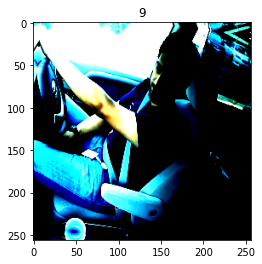

In [9]:
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
input_size = 256

# Split the data into training set and validation set
df_train, df_val = train_test_split(df, stratify=df['subject'], random_state=SEED)

transformer = DataTransform(input_size=input_size, color_mean=color_mean, color_std=color_std)

train_dataset = Dataset(df_train, phase="train", transform=transformer)

val_dataset = Dataset(df_val, phase="val", transform=transformer)

image, label = train_dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.show()

In [10]:
batch_size = 64

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [11]:
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, labels = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([8, 3, 256, 256])
print(labels.size())  # torch.Size([8])

torch.Size([64, 3, 256, 256])
torch.Size([64])


In [12]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)

# save checkpoint
def save_checkpoint(model, optimizer, scheduler, epoch, path):
    torch.save(
        {'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(), 
        }, path)

# load checkpoint
def load_checkpoint(model, optimizer, scheduler, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])

# set model parameters
def train_model(model, dataloaders_dict, criterion, scheduler, optimizer, device, num_epochs, save_path):
    # use GPU
    model.to(device)

    best_val_loss = float('inf')
    best_preds = None
    
    # train
    for epoch in range(num_epochs):

        # save start time
        t_epoch_start = time.time()
        epoch_train_loss = 0.0  # training loss
        epoch_val_loss = 0.0  # validation loss
        preds = []
        trues = []

        print('-------------')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-------------')

        # training and validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # train
            else:
                model.eval()   # validate
                print('-------------')
                
            # loop
            for i, (images, labels) in enumerate(dataloaders_dict[phase]):

                # use GPU
                images = images.to(device)
                labels = labels.to(device)

                # forward propagation
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    # backword propagation
                    if phase == 'train':
                        loss.backward()  # gradient
                        optimizer.step()
                        optimizer.zero_grad() # initialize gradient
                        epoch_train_loss += loss.item()/len(dataloaders_dict[phase].dataset)
                    # validation
                    else:
                        preds += [outputs.detach().cpu().softmax(dim=1).numpy()]
                        trues += [labels.detach().cpu()]
                        epoch_val_loss += loss.item()/len(dataloaders_dict[phase].dataset)
                    
                    # show process
                    if i%30 == 0:
                        print(f'[{phase}][{i+1}/{len(dataloaders_dict[phase])}] loss: {loss.item()/images.size(0): .4f}')
        
        if phase == 'train':
            scheduler.step()  # iterate
            
        # show process
        t_epoch_finish = time.time()
        print('-------------')
        print(f'epoch {epoch+1} epoch_train_Loss:{epoch_train_loss:.4f} epoch_val_loss:{epoch_val_loss:.4f} time: {t_epoch_finish - t_epoch_start:.4f} sec.')
        print(f'epoch_val_acc: {accuracy_score(np.concatenate(trues), np.concatenate(preds).argmax(axis=1))}')
        
        # save the model with the lowest validation loss
        if best_val_loss > epoch_val_loss:
            best_preds = np.concatenate(preds)
            best_val_loss = epoch_val_loss
            save_checkpoint(model, optimizer, scheduler, epoch, save_path)
            print("save model")
    return best_val_loss, best_preds

# parameters for 1-fold learning
def run_one_fold(df_train, df_val, fold, device):
    # create dataset
    train_dataset = Dataset(df_train, phase="train", transform=DataTransform(
        input_size=args.input_size, color_mean=args.color_mean, color_std=args.color_std))

    val_dataset = Dataset(df_val, phase="val", transform=DataTransform(
        input_size=args.input_size, color_mean=args.color_mean, color_std=args.color_std))
    
    # create dataloader
    train_dataloader = data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True)

    val_dataloader = data.DataLoader(
        val_dataset, batch_size=args.batch_size, shuffle=False)

    # construct corresponding dictionary
    dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

    # model definition
    model = EfficientNet.from_pretrained(args.model_name, num_classes=args.num_classes)
    optimizer = optim.Adam(model.parameters(), lr=args.lr) # optimization method
    criterion = nn.CrossEntropyLoss() # loss function
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma) # scheduler
    
    save_path = f"{args.model_name}_fold_{fold}.pth"
    best_val_loss, best_preds = train_model(model, dataloaders_dict, criterion, scheduler, optimizer, device, num_epochs=args.epochs, save_path=save_path)
    return best_val_loss, best_preds

# parameter for k-fold learning
def run_k_fold(df):
    # check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device：", device)
#     device = torch.device("cpu")
#     print("device：", device)
    
    # k-fold cross validation
    skf = StratifiedKFold(n_splits=args.folds, shuffle=True, random_state=SEED)
    oof = pd.DataFrame(index=df.index)
    for fold, (train_index, val_index) in enumerate(skf.split(df, df['subject'])):
        print(f'\n\nFOLD: {fold}')
        print('-'*50)
        df_train, df_val = df.loc[train_index], df.loc[val_index]
        best_val_loss, best_preds = run_one_fold(df_train, df_val, fold, device)
        oof.loc[val_index, activity_map.keys()] = best_preds
    return oof

# parameter for 0-fold learning
def run_no_fold(df):
    # check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device：", device)
    skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=SEED)
    oof = pd.DataFrame(index=df.index)
    for fold, (train_index, val_index) in enumerate(skf.split(df, df['subject'])):
        print(f'\n\nFOLD: {fold}')
        print('-'*50)
        df_train, df_val = df.loc[train_index], df.loc[val_index]
        best_val_loss, best_preds = run_one_fold(df_train, df_val, fold, device)
        oof.loc[val_index, activity_map.keys()] = best_preds
        break
    return oof

Loaded pretrained weights for efficientnet-b0


In [13]:
class args:
    model_name = 'efficientnet-b3'
    color_mean = (0.485, 0.456, 0.406)
    color_std = (0.229, 0.224, 0.225)
    input_size = 256
    num_classes = 10
    batch_size = 64
    epochs = 10
    folds = 3
    lr = 1e-3
    gamma = 0.98
    debug = False
    train = True

In [14]:
if args.debug:
    df_train = df.iloc[:1000]
else:
    df_train = df.copy()

if args.train:
    oof = run_k_fold(df_train)
    accuracy = accuracy_score(df_train['class_num'], oof.values.argmax(axis=1))
    print(f'\n\naccuracy: {accuracy}')

device： cuda


FOLD: 0
--------------------------------------------------
Loaded pretrained weights for efficientnet-b3
-------------
Epoch 1/10
-------------
[train][1/234] loss:  0.0365
[train][31/234] loss:  0.0057
[train][61/234] loss:  0.0061
[train][91/234] loss:  0.0050
[train][121/234] loss:  0.0024
[train][151/234] loss:  0.0026
[train][181/234] loss:  0.0024
[train][211/234] loss:  0.0002
-------------
[val][1/117] loss:  0.0010
[val][31/117] loss:  0.0000
[val][61/117] loss:  0.0000
[val][91/117] loss:  0.0000
-------------
epoch 1 epoch_train_Loss:0.0041 epoch_val_loss:0.0024 time: 321.4630 sec.
epoch_val_acc: 0.9673578595317726
save model
-------------
Epoch 2/10
-------------
[train][1/234] loss:  0.0026
[train][31/234] loss:  0.0008
[train][61/234] loss:  0.0007
[train][91/234] loss:  0.0010
[train][121/234] loss:  0.0026
[train][151/234] loss:  0.0007
[train][181/234] loss:  0.0002
[train][211/234] loss:  0.0001
-------------
[val][1/117] loss:  0.0007
[val][31/117] los